
# 1. Train and evaluate two different multiple regression models using different optimization algorithms. Describe your approach, interpret the performance, and justify which machine learning model you would choose.

In [5]:
import pandas as pd

# Load the Bike Shop dataset from Git
url = 'https://raw.githubusercontent.com/VAWi-DataScience/Data-Science-and-Machine-Learning/main/Assignment/WiSe22_23/02_Bike%20rental.csv'
bikeRentalDF = pd.read_csv(url)
import pandas as pd

# Drop the 'instant' column as it is just a record index and not useful for modeling
bikeRentalDF.drop('instant', axis=1, inplace=True)

# Convert 'dteday' column to datetime format
bikeRentalDF['dteday'] = pd.to_datetime(bikeRentalDF['dteday'])

# Create separate columns for year, month, and day from 'dteday' column
bikeRentalDF['year'] = bikeRentalDF['dteday'].dt.year
bikeRentalDF['month'] = bikeRentalDF['dteday'].dt.month
bikeRentalDF['day'] = bikeRentalDF['dteday'].dt.day

# Drop the 'dteday' column as we already extracted year, month, and day information
bikeRentalDF.drop('dteday', axis=1, inplace=True)


# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X = bikeRentalDF.drop(['cnt', 'casual', 'registered'], axis=1) # input features
y = bikeRentalDF['cnt'] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
bikeRentalDF


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011,1,1
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011,1,2
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011,1,3
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011,1,4
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114,2012,12,27
727,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095,2012,12,28
728,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341,2012,12,29
729,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796,2012,12,30


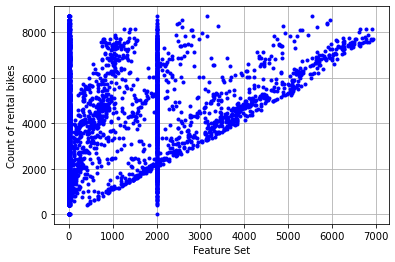

In [7]:
import matplotlib.pyplot as plt

feature_set = ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'year', 'month', 'day']
X = bikeRentalDF[feature_set]
y = bikeRentalDF.cnt
plt.figure(figsize=(6, 4))

plt.plot(X, y, "b.")
plt.xlabel("Feature Set")
plt.ylabel("Count of rental bikes")
#plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

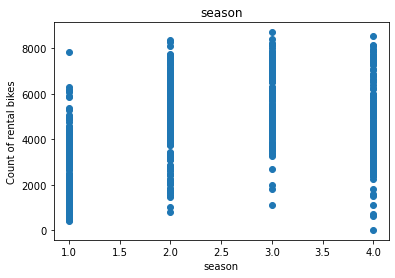

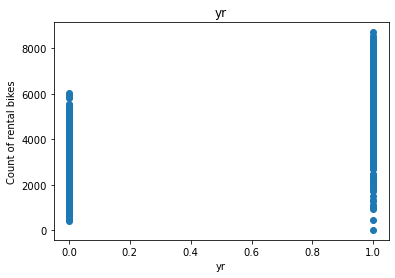

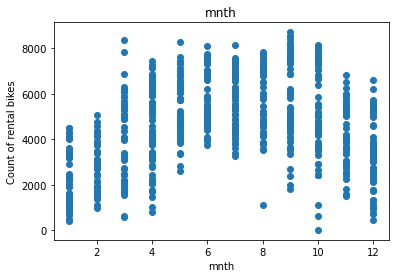

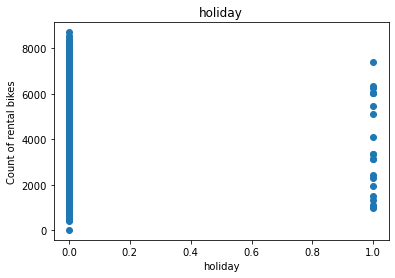

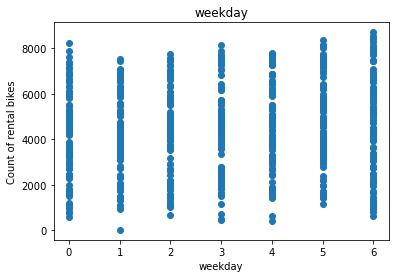

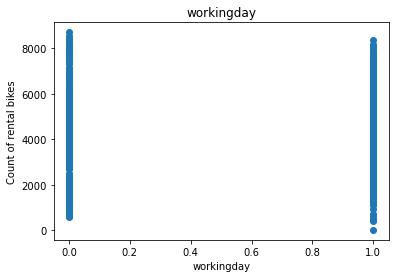

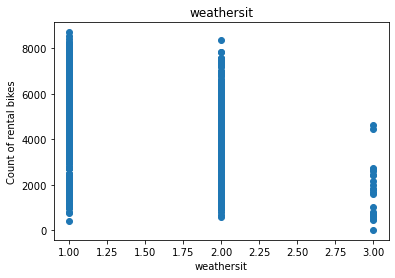

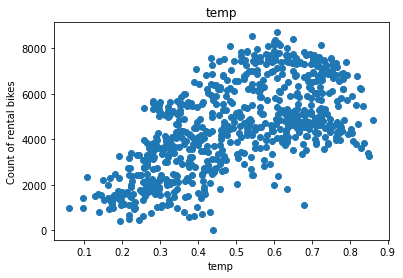

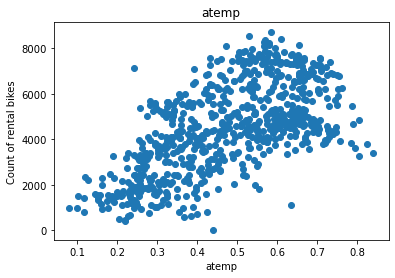

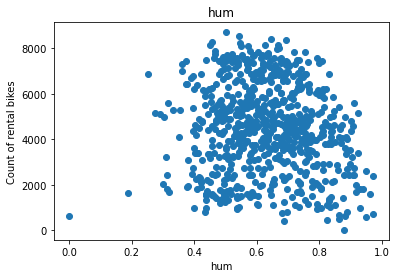

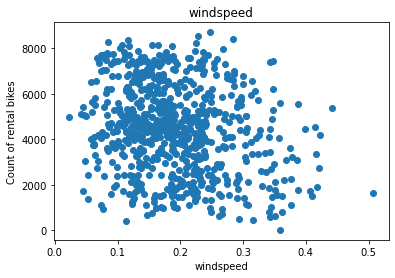

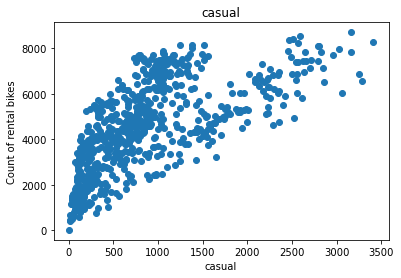

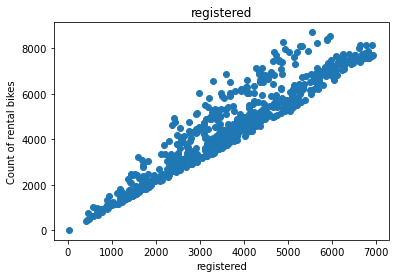

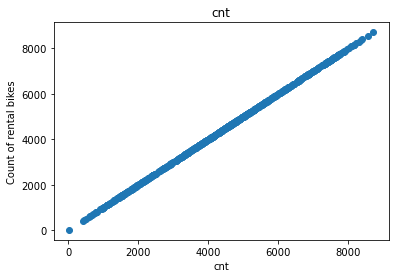

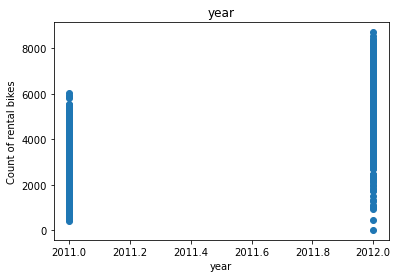

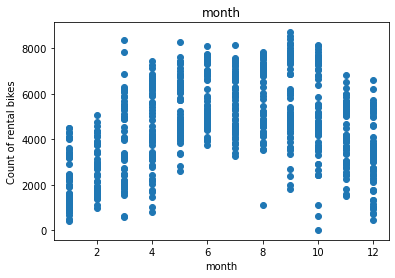

In [8]:
for label in bikeRentalDF.columns[0:-1]:
    plt.scatter(bikeRentalDF[label], bikeRentalDF["cnt"])
    plt.title(label)
    plt.ylabel("Count of rental bikes")
    plt.xlabel(label)
    plt.show()

In [2]:
from sklearn.linear_model import LinearRegression
# Fit a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Evaluate the performance of the model on the test set
y_pred = lin_reg.predict(X_test_scaled)

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

lin_reg.fit(X_train_scaled, y_train_scaled)

predictions_train_scaled = lin_reg.predict(X_train_scaled)
predictions_train = scaler.inverse_transform(predictions_train_scaled)

# Evaluate mean absolute error
print('Mean Absolute Error(MAE):', mean_absolute_error(y_train,predictions_train))

# Evaluate mean squared error
print("Mean Squared Error(MSE):", mean_squared_error(y_train, predictions_train))

# Evaluate root mean squared error
print("Root Mean Squared Error(RMSE):", np.sqrt(mean_squared_error(y_train, predictions_train)))

# Evaluate R2-square
print("R2-Square:",r2_score(y_train, predictions_train))


Mean Absolute Error(MAE): 585.1943728679979
Mean Squared Error(MSE): 648740.5778384353
Root Mean Squared Error(RMSE): 805.4443356548206
R2-Square: 0.8230241690061378
